### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely areare you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

In [13]:
#Import libraries
from mdp import MDP
import numpy as np
from mdp import FrozenLakeEnv
from matplotlib import pyplot
from IPython.display import clear_output
from time import sleep

Compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [2]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    Q = 0
    for s in mdp.get_next_states(state,action):
        Q += mdp.get_transition_prob(state,action,s)*(mdp.get_reward(state,action,s) + gamma*state_values[s])
    return Q

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [3]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as per formula above"""
    if mdp.is_terminal(state): return 0
    Q = []
    for a in mdp.get_possible_actions(state):
        Q.append(get_action_value(mdp,state_values,state,a,gamma))
    
    return np.max(Q)

### Value Iteration

__V__alue __I__teration algorithm

Pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]= \max_a Q_i(s, a)$, for all $s$

---

In [6]:
def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s : 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {s : get_new_state_value(mdp,state_values,s,gamma) for s in state_values.keys()}
        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f "%(i, diff, new_state_values[mdp._initial_state]))
        
        state_values = new_state_values
        if diff < min_difference:
            print("Terminated"); break
            
    return state_values

Find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

In [7]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state): return None
    Q = []
    for a in mdp.get_possible_actions(state):
        Q.append(get_action_value(mdp, state_values, state, a, gamma))
    return mdp.get_possible_actions(state)[np.argmax(Q)]

**Visualization**

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

### Frozen Lake

In [21]:
mdp = FrozenLakeEnv(slip_chance=0.1)
mdp.render()

*FFF
FHFH
FFFH
HFFG



In [22]:
state_values = value_iteration(mdp)

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
Terminated


In [26]:
s = mdp.reset()
mdp.render()
gamma = 0.9
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done: break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FF*H
HFFG

down

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



after iteration 0
iter    0   |   diff: 0.90000   |   V(start): 0.000 


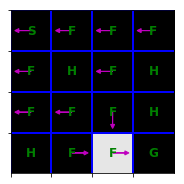

after iteration 1
iter    0   |   diff: 0.72900   |   V(start): 0.000 


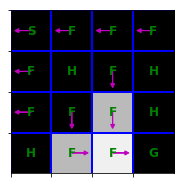

after iteration 2
iter    0   |   diff: 0.62330   |   V(start): 0.000 


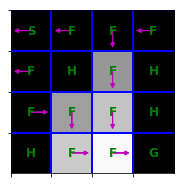

after iteration 3
iter    0   |   diff: 0.50487   |   V(start): 0.000 


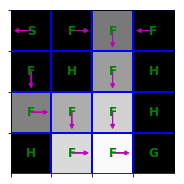

after iteration 4
iter    0   |   diff: 0.40894   |   V(start): 0.000 


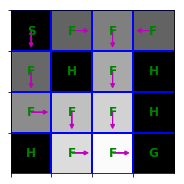

after iteration 5
iter    0   |   diff: 0.34868   |   V(start): 0.349 


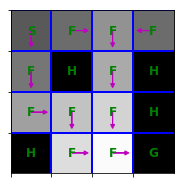

after iteration 6
iter    0   |   diff: 0.06529   |   V(start): 0.410 


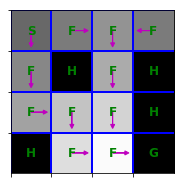

after iteration 7
iter    0   |   diff: 0.05832   |   V(start): 0.468 


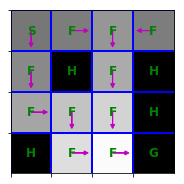

after iteration 8
iter    0   |   diff: 0.01139   |   V(start): 0.480 


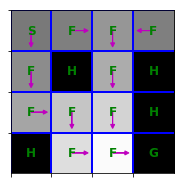

after iteration 9
iter    0   |   diff: 0.00764   |   V(start): 0.487 


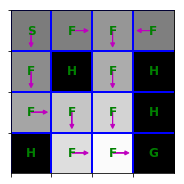

In [27]:
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 
Terminated


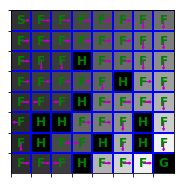

In [32]:
mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)

In [33]:
total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))

average reward:  0.868
